squeeze:tensor([1, 1])


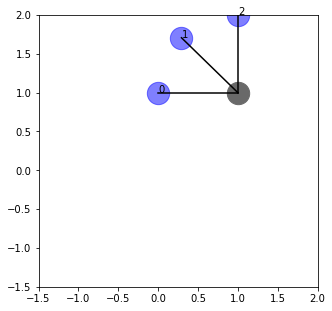

D:\Anaconda3\envs\conv_qsar\lib\site-packages\ipykernel_launcher.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [4]:
# the purpose of this test is to check if the 2D kernel can learn to generate pattern present in the training data
# step 1. test of data with same attributes with the same length
# step 2  test of data with same attributes with the different length
# step 3. test with different attributes  and different length

# data generation
import torch
import matplotlib.pyplot as plt
import math
from torch_geometric.data import Data

# S = 3
x = torch.tensor([[1],[1],[1]], dtype = torch.float)
p = torch.tensor([[-1,0],[-math.sqrt(0.5),math.sqrt(0.5)],[0,1]], dtype = torch.float)



#S = 4
# data
# x = torch.tensor([[1],[1],[1],[1]], dtype = torch.float)
# p = torch.tensor([[-1,0],[-math.sqrt(0.5),math.sqrt(0.5)],[0,1], [math.sqrt(0.5), math.sqrt(0.5)]], dtype = torch.float)

# translate

trans = torch.tensor([[1,1]])
p+=trans

def color_for_element(atomic_num):
    color ='lightgrey'
    if(atomic_num == 1):
        color = 'lightgrey'
    elif(atomic_num ==6):
        color = 'black'
    elif(atomic_num ==8):
        color = 'red'
    elif(atomic_num ==7):
        color = 'blue'
    return color

def vis(p, origin, x = None):
    fig_size = 5
    marker_size = 500
    lower_bound = -1.5
    upper_bound = 2
    
    plt.figure(figsize = (fig_size,fig_size))
    plt.xlim(lower_bound,upper_bound)
    plt.ylim(lower_bound,upper_bound)
    
    if isinstance(p, Data):
        p = p.p

    
    for i in range(p.shape[0]):
        if x is None:
            plt.annotate(i, (p[i,:]))
            color = 'blue'
        else:
            pt = Chem.GetPeriodicTable() 
            atomic_num = int(x[i,0].item())
            plt.annotate(pt.GetElementSymbol(atomic_num),(p[i,:]))
            marker_size = x[i,2].item()*500
            color = color_for_element(atomic_num)
        plt.scatter(p[i,0], p[i,1], color = color, s = marker_size, alpha = 0.5)
        
        
    plt.scatter(origin[0], origin[1], color = 'dimgrey', s= marker_size)
    for each_p in p:
        plt.plot([each_p[0], origin[0]],[each_p[1],origin[1]], color = 'black')
    plt.show()    

print(f'squeeze:{trans.squeeze(dim=0)}')
origin = torch.tensor([0,0]) + trans.squeeze(dim =0)
vis(p, origin)


def rotate(origin, point, angle):
    """
    Rotate a point counterclockwise by a given angle around a given origin.

    The angle should be given in degrees.
    """
    angle = angle * math.pi/180
    
    ox, oy = origin
#     print(f'ox:{ox}, oy:{oy}')
    px, py = point
#     print(f'px:{px}, py:{py}')
    qx = ox + math.cos(angle) * (px - ox) - math.sin(angle) * (py - oy)
    qy = oy + math.sin(angle) * (px - ox) + math.cos(angle) * (py - oy)
    return torch.tensor([qx, qy])

def tensor_rotate(origin, points, angle):
    l = []
    for point in points:
        new_p = rotate(origin, point, angle)
        l.append(new_p)
    l = torch.stack(l, dim=0)
#     print(f'f:{l.shape}')
    return torch.tensor(l)
        
new_p = tensor_rotate(origin, p, 180)
# print(new_p)
# vis(new_p, origin)

data_list = []
for i in range(0, 370, 10):
    new_p = tensor_rotate(origin, p, i)
    data = Data(p = new_p, origin = origin)
    data_list.append(data)

# for data in data_list:
#     vis(data, origin)


In [ ]:
# conv
from torch_geometric.nn import MessagePassing
from torch.nn import CosineSimilarity
from torch.nn import Linear, Sigmoid
from torch.nn import Module
from itertools import permutations
from torch.nn.parameter import Parameter


# kernel = Data(p_s = p_s)
# same_kernel = Data(p_s = p)
sig = Sigmoid()

def permute(x):
    rows = x.shape[0]
    l = [x[torch.tensor(permute)] for permute in list(permutations(range(rows)))]
    return l

class Kernel(Module):
    def __init__(self, init_kernel=None, S = 3):
        super(Kernel, self).__init__()
        if init_kernel is None:
            if S is None:
                raise Exception('S is not specified')
            else:
                init_kernel = Data(p_s = torch.randn(S,2))
#             print(init_kernel.p_s)
        p_s_tensor = init_kernel.p_s#torch.tensor([[1,0],[-math.sqrt(0.5),-math.sqrt(0.5)],[0,1]], dtype = torch.float)
        p_s = Parameter(p_s_tensor)
        self.p_s = p_s
        
    def self_sim(self,p):
        cos = CosineSimilarity(dim = 1)
#         for i in p.shape[0]
        new_p = torch.roll(p,1,0)
#         print('\n')
#         print(f'p:{p}')
#         print(f'new_p:{new_p}')
        sc = cos(new_p, p)
#         print(f'sc:{sc}')
        return sc
    
    def sim(self, p, p_s):
        cos = CosineSimilarity(dim = 0)
#         print('p_dist:')
        inter_p_dist = self.self_sim(p)
#         print('\n')
#         print('s_dist:')
        inter_p_s_dist = self.self_sim(p_s)
#         print(f'inter_p_s_dist:{inter_p_s_dist}')
        sc = cos(inter_p_dist, inter_p_s_dist)
#         sc = torch.dot(inter_p_dist, inter_p_s_dist.T)
#         print(sc)
        return sc

    def length_sim(self, p, p_s):
        len_p = torch.norm(p, dim = -1)
        len_p_s = torch.norm(p_s, dim = -1)
#         print(len_p.shape)
        
        # cos similarity
        cos = CosineSimilarity(dim = 0)
        sc = cos(len_p,len_p_s)
        
        # dot product similarity
#         act = Sigmoid()
#         sc = act(torch.sum(p*p_s))

        # inverse of l1 norm
        diff = len_p - len_p_s
        sc = 1/diff
    
        # inverse of L2 norm
        diff = torch.square(len_p - len_p_s)
        sc = torch.sum(diff)
        sc = torch.atan(1/sc)
    
#         print(sc)
        return sc
    
    def forward(self, data):
        score=0
        p = data.p - data.origin
        p_s = self.p_s
        
        p_s_list = permute(p_s)
#         print(f'permute len:{len(p_s_list)}')
    
        
        max_angle_sc = torch.tensor(-float('Inf'))
        max_index = 0
        for i, each_p_s in enumerate(p_s_list):
#             print('\n')
#             print(f'i:{i}')
#             print(f'each_p_s:\n{each_p_s}')
#             print(f'p:\n{p}')
            angle_sc = self.sim(p, each_p_s)
#             print(f'{i} angle_sc:{angle_sc}, max_angle_sc:{max_angle_sc}, max_index:{max_index}')
            if angle_sc > max_angle_sc:
                max_index = i
                max_angle_sc = angle_sc
        
        # get the p and p_s combination that gives the best angle score
        best_p_s = p_s_list[max_index]
        length_sc = self.length_sim(p, best_p_s)
        
        length_sc = length_sc.unsqueeze(dim = 0)
        max_angle_sc = max_angle_sc.unsqueeze(dim = 0)
        
#         print(length_sc.shape)
#         print(max_angle_sc.shape)
        
        one = torch.tensor([math.pi/2])
        
        sc = torch.atan(1/(torch.square(length_sc-one) + torch.square(max_angle_sc-one)))

        print(f'len sc:{length_sc}, angle sc:{max_angle_sc}, total sc: {sc}')
        return sc
        

# class Graph3DConv(MessagePassing):
#     def __init__(self, kernel):
#         super(Graph3DConv, self).__init__()
#         self.kernel = kernel
# #         self.lin = Linear(3,2)
    

            
        
#     def message(self):
#         pass



# data = data_list[0]

# print('less similar')
# p_s = torch.tensor([[5,0],[-math.sqrt(2.5),-math.sqrt(2.5)],[0,5]], dtype = torch.float)
# kernel = Data(p_s = p_s)
# model = Kernel(kernel)
# out = model(data)
# # print(out)

# print('\n')
# print('less similar')
# p_s = torch.tensor([[1.5,0],[1.4,0],[0,1.5]], dtype = torch.float)
# kernel = Data(p_s = p_s)
# model = Kernel(kernel)
# out = model(data)

# print('\n')
# print('more similar')
# p_s = torch.tensor([[1.3,0],[1.2,0],[0,1.0]], dtype = torch.float)
# kernel = Data(p_s = p_s)
# model = Kernel(kernel)
# out = model(data)


# print('\n')
# print('length same')
# p_s = torch.tensor([[1,0],[-math.sqrt(0.5),-math.sqrt(0.5)],[0,1]], dtype = torch.float)
# kernel = Data(p_s = p_s)
# model = Kernel(kernel)
# out = model(data)

# print('\n')
# print('totally same')
# kernel = Data(p_s = (p-origin))
# model = Kernel(kernel)
# out = model(data)


In [ ]:
# reset kernel and check kernel before training
import numpy as np
def angle_between_two_vectors(vector_1, vector_2):

#     print('\n')
#     print('vector1:')
#     print(vector_1)
#     print('vector2:')
#     print(vector_2)
    
    unit_vector_1 = vector_1 / np.linalg.norm(vector_1)
#     print('norm vector1:')
#     print(unit_vector_1)
    
    unit_vector_2 = vector_2 / np.linalg.norm(vector_2)
#     print('norm vector2:')
#     print(unit_vector_2)
    
    dot_product = np.dot(unit_vector_1, unit_vector_2)
#     print(f'dot:{dot_product}')
    angle = np.arccos(dot_product)
    angle = angle/math.pi *180
    return angle

def edge_length(vector):
    return np.linalg.norm(vector)

p_s_origin = torch.tensor([0,0])
# S = 3
S = 3
x_c = torch.tensor([[1]], dtype = torch.float)
x_s = torch.tensor([[1],[1],[1]], dtype = torch.float)
p_s = torch.tensor([[1,0],[-math.sqrt(0.5),-math.sqrt(0.5)],[0,1]], dtype = torch.float)

# # S = 4
# # kernel
# S = 4
# x_c = torch.tensor([[1]], dtype = torch.float)
# x_s = torch.tensor([[1],[1],[1]], dtype = torch.float)
# p_s = torch.tensor([[1,0],[-math.sqrt(0.5),-math.sqrt(0.5)],[0,1], [math.sqrt(0.5), -math.sqrt(0.5)]], dtype = torch.float)

kernel = Data(p_s = p_s)
model = Kernel(kernel)
# randomize kernel
model = Kernel(S =S)
params = model.parameters()
param = list(params)[0].detach().numpy()

for i in range(S):
    for j in range(i):
        print(f'{i}-{j} angle:{angle_between_two_vectors(param[i], param[j])}')
print('\n')
for i in range(S):
    print(f'{i} length:{edge_length(param[i])}')


output_kernel = Data(p_s = torch.tensor(param))
output_model = Kernel(output_kernel)
out = output_model(data)

vis(param, p_s_origin)

In [ ]:
# training without attributed data
from torch.optim import Adam
from torch.nn import MSELoss, CrossEntropyLoss
import random

torch.set_printoptions(precision=6)
random.seed(None)
optimizer = Adam(model.parameters(), lr=0.01)  # Define optimizer.

# Loss func selection
criterion = MSELoss()
# criterion = CosineSimilarity(dim = 0)
# criterion = CrossEngropyLoss

def train():
    random.shuffle(data_list)
    for data in data_list:
        out = model(data)
        label = torch.tensor(math.pi/2, dtype= torch.float)
#         print(out)
        loss = criterion(out, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
#     print(loss)

for i in range(20):
    print(f'epoch {i}')
    train()
    
    # turn on this to visulize each step
#     params = model.parameters()
#     param = list(params)[0].detach().numpy()
#     vis(param, p_s_origin)
    


In [ ]:
# visualize kernel in the model without attributed data

params = model.parameters()
param = list(params)[0].detach().numpy()
print(param)



# print('param[0]:')
# print(param[0])
# print('param[1]:')
# print(param[1])
# print('param[2]:')
# print(param[2])

for i in range(S):
    for j in range(i):
        print(f'{i}-{j} angle:{angle_between_two_vectors(param[i], param[j])}')
print('\n')
for i in range(S):
    print(f'{i} length:{edge_length(param[i])}')

output_kernel = Data(p_s = torch.tensor(param))
output_model = Kernel(output_kernel)
out = output_model(data)



vis(param, p_s_origin)



calculating rdkit element representation lookup table
tensor([[ 1.299038e+00,  7.500000e-01],
        [-1.299038e+00,  7.500000e-01],
        [-2.775558e-16, -1.500000e+00]])
tensor([-5.551115e-17, -5.551115e-17])
tensor([[ 8.000000, 15.999000,  1.550000,  2.000000,  6.000000],
        [ 1.000000,  1.008000,  1.200000,  1.000000,  1.000000],
        [ 1.000000,  1.008000,  1.200000,  1.000000,  1.000000]])
Data(origin=[2], p=[3, 2], x=[3, 5])


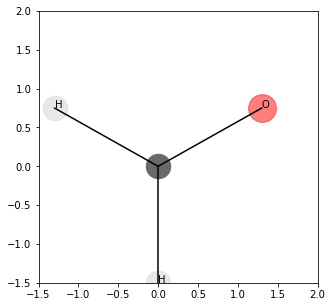

D:\Anaconda3\envs\conv_qsar\lib\site-packages\ipykernel_launcher.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [26]:
# test of p with different attributes
from rdkit import Chem
from rdkit.Chem import AllChem
import rdkit
import torch
from torch_geometric.data import Data

elements = ['H', 'C', 'N', 'O', 'P', 'S', 'F', 'Cl', 'Br', 'I']
elem_lst =None


def lookup_from_rdkit(elements):
	global elem_lst

	if elem_lst is None:
		print('calculating rdkit element representation lookup table')
		elem_rep_lookup = []
		for elem in elements:
			pt = Chem.GetPeriodicTable() 
			
			if isinstance(elem, int):
				num=elem
				sym=pt.GetElementSymbol(num)
			else:
				num = pt.GetAtomicNumber(elem)
				sym = elem
			w = pt.GetAtomicWeight(elem)
			
			Rvdw = pt.GetRvdw(elem)
		#     Rcoval = pt.GetRCovalent(elem)
			valence = pt.GetDefaultValence(elem)
			outer_elec = pt.GetNOuterElecs(elem)



			elem_rep=[num, w,  Rvdw, valence, outer_elec]
	#         print(elem_rep)


			elem_rep_lookup.append(elem_rep)
		elem_lst = elem_rep_lookup.copy()
		return elem_rep_lookup
	else:
		return elem_lst




def get_atom_rep(atomic_num, package):
	'''use rdkit or pymatgen to generate atom representation
	'''
	max_elem_num = 118
	element_nums= [x+1 for x in range(max_elem_num)]


	if package =='rdkit':
		elem_lst = lookup_from_rdkit(element_nums)
	elif package == 'pymatgen':
		elem_lst = lookup_from_pymatgen(element_nums)
	else:
		raise Exception('cannot generate atom representation lookup table')
		
	result = 0
	try:
		result = elem_lst[atomic_num - 1]
	except:
		print(f'error: atomic_num {atomic_num} does not exist')


	return result


smiles = 'C(=O)([H])[H]'
mol = Chem.MolFromSmiles(smiles)
mol = Chem.AddHs(mol)

# for 3D
# AllChem.EmbedMolecule(mol)
# AllChem.UFFOptimizeMolecule(mol)
# conf = mol.GetConformer()

# for 2D
rdkit.Chem.rdDepictor.Compute2DCoords(mol)
conf = mol.GetConformer()
atom_pos = []
atom_attr =[]
for i, atom in enumerate(mol.GetAtoms()):
    atomic_num = atom.GetAtomicNum()
    h = get_atom_rep(atomic_num, 'rdkit')
    if atomic_num == 6:
        origin = torch.tensor([conf.GetAtomPosition(i).x, conf.GetAtomPosition(i).y])#, conf.GetAtomPosition(i).z ])
    else:
        atom_pos.append([conf.GetAtomPosition(i).x, conf.GetAtomPosition(i).y])#, conf.GetAtomPosition(i).z])
        atom_attr.append(h)
                              
p = torch.tensor(atom_pos)
x = torch.tensor(atom_attr)                              

print(p)
print(origin)
print(x)
                            
data = Data(p=p, x=x, origin= origin)
print(data)
vis(data.p, data.origin, x)

data_list = []
for i in range(0, 370, 10):
    new_p = tensor_rotate(origin, p, i)
    data = Data(p = new_p, origin = origin, x=x)
    data_list.append(data)



In [67]:
# conv with attributes
from torch_geometric.nn import MessagePassing
from torch.nn import CosineSimilarity
from torch.nn import Linear, Sigmoid
from torch.nn import Module
from itertools import permutations
from torch.nn.parameter import Parameter


# kernel = Data(p_s = p_s)
# same_kernel = Data(p_s = p)
sig = Sigmoid()



class Kernel(Module):
    def __init__(self, init_kernel=None, dim=2, S = 3, f_dim=5):
        super(Kernel, self).__init__()
        if init_kernel is None:
            
            if S is None or f_dim is None:
                raise Exception('S or f_dim is not specified')
            else:
                print('randomizing kernel')
                init_kernel = Data(p_s = torch.randn(S,2), x_s = torch.randn(S,f_dim))
#             print(init_kernel.p_s)
        
        p_s_tensor = init_kernel.p_s#torch.tensor([[1,0],[-math.sqrt(0.5),-math.sqrt(0.5)],[0,1]], dtype = torch.float)
        p_s = Parameter(p_s_tensor)
        self.p_s = p_s
        
        x_s_tensor = init_kernel.x_s
        x_s = Parameter(x_s_tensor)
        self.x_s = x_s

        
    def permute(x):
        rows = x.shape[0]
        l = [x[torch.tensor(permute)] for permute in list(permutations(range(rows)))]
        return l        
        
    def self_sim(self,p):
        cos = CosineSimilarity(dim = 1)
#         for i in p.shape[0]
        new_p = torch.roll(p,1,0)
#         print('\n')
#         print(f'p:{p}')
#         print(f'new_p:{new_p}')
        sc = cos(new_p, p)
#         print(f'sc:{sc}')
        return sc
    
    def sim(self, p, p_s):
        cos = CosineSimilarity(dim = 0)
#         print('p_dist:')
        inter_p_dist = self.self_sim(p)
#         print('\n')
#         print('s_dist:')
        inter_p_s_dist = self.self_sim(p_s)
#         print(f'inter_p_s_dist:{inter_p_s_dist}')
        sc = cos(inter_p_dist, inter_p_s_dist)
#         sc = torch.dot(inter_p_dist, inter_p_s_dist.T)
#         print(sc)
        return sc

    def length_sim(self, p, p_s):
        len_p = torch.norm(p, dim = -1)
        len_p_s = torch.norm(p_s, dim = -1)
#         print(len_p.shape)
        
        # cos similarity
        cos = CosineSimilarity(dim = 0)
        sc = cos(len_p,len_p_s)
        
        # dot product similarity
#         act = Sigmoid()
#         sc = act(torch.sum(p*p_s))

        # inverse of l1 norm
        diff = len_p - len_p_s
        sc = 1/diff
    
        # inverse of L2 norm
        diff = torch.square(len_p - len_p_s)
        sc = torch.sum(diff)
        sc = torch.atan(1/sc)
    
#         print(sc)
        return sc
    
    def attribute_sim(self, x, x_s):

        
        # cos similarity
        cos = CosineSimilarity(dim = 0)
        sc = cos(x,x_s)
        
        # dot product similarity
#         act = Sigmoid()
#         sc = act(torch.sum(p*p_s))

        # inverse of l1 norm
        diff = x - x_s
        sc = 1/diff
    
        # inverse of L2 norm
        diff = torch.square(x - x_s)
        sc = torch.sum(diff)
        sc = torch.atan(1/sc)
    
#         print(sc)
        return sc
    
    def forward(self, data):
        score=0
        p = data.p - data.origin
        x = data.x
        p_s = self.p_s
        x_s = self.x_s
        
        p_s_list = permute(p_s)
        x_s_list = permute(x_s)
#         print(f'permute len:{len(p_s_list)}')
    
        
        max_angle_sc = torch.tensor(-float('Inf'))
        max_index = 0
        for i, each_p_s in enumerate(p_s_list):
#             print('\n')
#             print(f'i:{i}')
#             print(f'each_p_s:\n{each_p_s}')
#             print(f'p:\n{p}')
            angle_sc = self.sim(p, each_p_s)
#             print(f'{i} angle_sc:{angle_sc}, max_angle_sc:{max_angle_sc}, max_index:{max_index}')
            if angle_sc > max_angle_sc:
                max_index = i
                max_angle_sc = angle_sc
        
        # get the p and p_s combination that gives the best angle score
        best_p_s = p_s_list[max_index]
        length_sc = self.length_sim(p, best_p_s)

        best_x_s = x_s_list[max_index]
        attr_sc = self.attribute_sim(x, best_x_s)
        
        length_sc = length_sc.unsqueeze(dim = 0)
        max_angle_sc = max_angle_sc.unsqueeze(dim = 0)
        attr_sc = attr_sc.unsqueeze(dim=0)
        
#         print(length_sc.shape)
#         print(max_angle_sc.shape)
        
        goal_sc = torch.tensor([math.pi/2])
        one = torch.tensor([1])
        
        sc = torch.atan(1/(torch.square(length_sc-goal_sc) + torch.square(max_angle_sc-one)+ torch.square(attr_sc-goal_sc)))
        
        print('\n')
        print(f'len sc:{length_sc.item()}')
        print(f'angle sc:{max_angle_sc.item()}')
        print(f'attribute_sc:{attr_sc.item()}')
        print(f'total sc: {sc.item()}')
        return sc
        

# class Graph3DConv(MessagePassing):
#     def __init__(self, kernel):
#         super(Graph3DConv, self).__init__()
#         self.kernel = kernel
# #         self.lin = Linear(3,2)
    

            
        
#     def message(self):
#         pass



# data = data_list[0]

# print('less similar')
# p_s = torch.tensor([[5,0],[-math.sqrt(2.5),-math.sqrt(2.5)],[0,5]], dtype = torch.float)
# kernel = Data(p_s = p_s)
# model = Kernel(kernel)
# out = model(data)
# # print(out)

# print('\n')
# print('less similar')
# p_s = torch.tensor([[1.5,0],[1.4,0],[0,1.5]], dtype = torch.float)
# kernel = Data(p_s = p_s)
# model = Kernel(kernel)
# out = model(data)

# print('\n')
# print('more similar')
# p_s = torch.tensor([[1.3,0],[1.2,0],[0,1.0]], dtype = torch.float)
# kernel = Data(p_s = p_s)
# model = Kernel(kernel)
# out = model(data)


# print('\n')
# print('length same')
# p_s = torch.tensor([[1,0],[-math.sqrt(0.5),-math.sqrt(0.5)],[0,1]], dtype = torch.float)
# kernel = Data(p_s = p_s)
# model = Kernel(kernel)
# out = model(data)

# print('\n')
# print('totally same')
# kernel = Data(p_s = (p-origin))
# model = Kernel(kernel)
# out = model(data)


randomizing kernel
init kernel positioin
[[ 0.7652141 -1.5598882]
 [ 1.6052285  0.352245 ]
 [-0.8016341  0.1740662]]


init kernel attribute
[[ 0.5657299   2.3174422  -0.63282    -1.4919811   0.18586075]
 [ 0.23088598  0.47615668  1.4460511  -0.7976878  -1.657509  ]
 [ 0.94301736  0.28370938 -1.10131     1.35312     1.8621215 ]]
1-0 angle:76.24601642187764
2-0 angle:128.38156069625865
2-1 angle:155.37243289977638


0 length:1.7374706268310547
1 length:1.6434217691421509
2 length:0.8203147053718567


len sc:1.0764886140823364
angle sc:0.6624243259429932
attribute_sc:0.00321400654502213
total sc: 0.34126654267311096


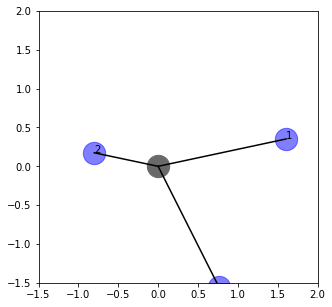

In [57]:
# reset kernel and check kernel before training with attributed data
import numpy as np
def angle_between_two_vectors(vector_1, vector_2):

#     print('\n')
#     print('vector1:')
#     print(vector_1)
#     print('vector2:')
#     print(vector_2)
    
    unit_vector_1 = vector_1 / np.linalg.norm(vector_1)
#     print('norm vector1:')
#     print(unit_vector_1)
    
    unit_vector_2 = vector_2 / np.linalg.norm(vector_2)
#     print('norm vector2:')
#     print(unit_vector_2)
    
    dot_product = np.dot(unit_vector_1, unit_vector_2)
#     print(f'dot:{dot_product}')
    angle = np.arccos(dot_product)
    angle = angle/math.pi *180
    return angle

def edge_length(vector):
    return np.linalg.norm(vector)

p_s_origin = torch.tensor([0,0])
# S = 3
S = 3
x_c = torch.tensor([[1]], dtype = torch.float)
x_s = torch.tensor([[1],[1],[1]], dtype = torch.float)
p_s = torch.tensor([[1,0],[-math.sqrt(0.5),-math.sqrt(0.5)],[0,1]], dtype = torch.float)

# # S = 4
# # kernel
# S = 4
# x_c = torch.tensor([[1]], dtype = torch.float)
# x_s = torch.tensor([[1],[1],[1]], dtype = torch.float)
# p_s = torch.tensor([[1,0],[-math.sqrt(0.5),-math.sqrt(0.5)],[0,1], [math.sqrt(0.5), -math.sqrt(0.5)]], dtype = torch.float)

h_list = []
for i in range(S):
    h = get_atom_rep(8, 'rdkit')
    h_list.append(h)
x_s = torch.tensor(h_list)

kernel = Data(p_s = p_s, x_s = x_s)
# model = Kernel(kernel)
# randomize kernel
model = Kernel()
params = model.parameters()

param = list(params)


p_s_array = param[0].detach().numpy()
x_s_array = param[1].detach().numpy()
print('init kernel positioin')
print(p_s_array)
print('\n')
print('init kernel attribute')
print(x_s_array)


for i in range(S):
    for j in range(i):
        print(f'{i}-{j} angle:{angle_between_two_vectors(p_s_array[i], p_s_array[j])}')
print('\n')
for i in range(S):
    print(f'{i} length:{edge_length(p_s_array[i])}')


output_kernel = Data(p_s = torch.tensor(p_s_array), x_s = torch.tensor(x_s_array))
output_model = Kernel(output_kernel)
out = output_model(data)

vis(p_s_array, p_s_origin)

In [58]:
# training with attributed data
from torch.optim import Adam
from torch.nn import MSELoss, CrossEntropyLoss
import random

torch.set_printoptions(precision=6)
random.seed(None)
optimizer = Adam(model.parameters(), lr=0.01)  # Define optimizer.

# Loss func selection
criterion = MSELoss()
# criterion = CosineSimilarity(dim = 0)
# criterion = CrossEngropyLoss

def train():
    random.shuffle(data_list)
    for data in data_list:
        out = model(data)
        label = torch.tensor(math.pi/2, dtype= torch.float)
#         print(out)
        loss = criterion(out, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
#     print(loss)

for i in range(20):
    print(f'epoch {i}')
    train()
    
    # turn on this to visulize each step
#     params = model.parameters()
#     param = list(params)[0].detach().numpy()
#     vis(param, p_s_origin)
    


epoch 0


len sc:1.0764884948730469
angle sc:0.6624243855476379
attribute_sc:0.00321400654502213
total sc: 0.34126654267311096


len sc:1.0955615043640137
angle sc:0.6692660450935364
attribute_sc:0.003222877625375986
total sc: 0.3438721001148224


len sc:1.1144330501556396
angle sc:0.6761202216148376
attribute_sc:0.0032317708246409893
total sc: 0.3464012145996094


len sc:1.1330485343933105
angle sc:0.6829929947853088
attribute_sc:0.0032406847458332777
total sc: 0.34884724020957947


len sc:1.151353120803833
angle sc:0.6898903846740723
attribute_sc:0.003249624976888299
total sc: 0.3512043058872223


len sc:1.1692936420440674
angle sc:0.6968178749084473
attribute_sc:0.003258590353652835
total sc: 0.35346752405166626


len sc:1.1868188381195068
angle sc:0.7037813663482666
attribute_sc:0.0032675848342478275
total sc: 0.35563308000564575


len sc:1.2038813829421997
angle sc:0.7107861042022705
attribute_sc:0.003276609815657139
total sc: 0.35769832134246826


len sc:1.2204394340515137
angle 



len sc:1.5481427907943726
angle sc:0.9832252860069275
attribute_sc:0.004324610810726881
total sc: 0.3868638873100281


len sc:1.54837167263031
angle sc:0.9833742380142212
attribute_sc:0.004335539881139994
total sc: 0.38687095046043396


len sc:1.5485961437225342
angle sc:0.9835205078125
attribute_sc:0.0032110169995576143
total sc: 0.38637202978134155
epoch 3


len sc:1.548816442489624
angle sc:0.9836640954017639
attribute_sc:0.004357038531452417
total sc: 0.3868846893310547


len sc:1.5490325689315796
angle sc:0.9838051199913025
attribute_sc:0.004367692396044731
total sc: 0.3868914842605591


len sc:1.54924476146698
angle sc:0.98394376039505
attribute_sc:0.0030025728046894073
total sc: 0.3862852156162262


len sc:1.5494531393051147
angle sc:0.9840799570083618
attribute_sc:0.003006682498380542
total sc: 0.38628894090652466


len sc:1.5496575832366943
angle sc:0.9842138290405273
attribute_sc:0.004398242104798555
total sc: 0.3869107961654663


len sc:1.549858570098877
angle sc:0.9843456



len sc:1.5607712268829346
angle sc:0.991940438747406
attribute_sc:0.005705775693058968
total sc: 0.3875703811645508


len sc:1.560826063156128
angle sc:0.9919813871383667
attribute_sc:0.0057203867472708225
total sc: 0.3875771164894104
epoch 6


len sc:1.560880422592163
angle sc:0.992021918296814
attribute_sc:0.005735933780670166
total sc: 0.387584388256073


len sc:1.5609344244003296
angle sc:0.9920622110366821
attribute_sc:0.005752333905547857
total sc: 0.3875919580459595


len sc:1.5609878301620483
angle sc:0.9921020865440369
attribute_sc:0.005769513547420502
total sc: 0.3875998258590698


len sc:1.5610407590866089
angle sc:0.9921417236328125
attribute_sc:0.005787406582385302
total sc: 0.3876080811023712


len sc:1.5610932111740112
angle sc:0.9921808838844299
attribute_sc:0.003263981081545353
total sc: 0.3864821195602417


len sc:1.5611451864242554
angle sc:0.992219865322113
attribute_sc:0.005822414066642523
total sc: 0.38762417435646057


len sc:1.5611966848373413
angle sc:0.99225

len sc:1.5649012327194214
angle sc:0.9951153993606567
attribute_sc:0.008354066871106625
total sc: 0.38877221941947937


len sc:1.564923882484436
angle sc:0.9951333999633789
attribute_sc:0.008385872468352318
total sc: 0.38878655433654785


len sc:1.5649464130401611
angle sc:0.9951512813568115
attribute_sc:0.008419197984039783
total sc: 0.38880157470703125


len sc:1.5649688243865967
angle sc:0.9951691031455994
attribute_sc:0.008453929796814919
total sc: 0.38881731033325195


len sc:1.5649912357330322
angle sc:0.9951869249343872
attribute_sc:0.0030751083977520466
total sc: 0.38641196489334106


len sc:1.5650132894515991
angle sc:0.9952044486999512
attribute_sc:0.0030720909126102924
total sc: 0.3864107131958008


len sc:1.565035343170166
angle sc:0.9952219724655151
attribute_sc:0.008550082333385944
total sc: 0.3888606131076813


len sc:1.5650571584701538
angle sc:0.9952394366264343
attribute_sc:0.008580326102674007
total sc: 0.3888742923736572


len sc:1.565078854560852
angle sc:0.9952567



len sc:1.5668717622756958
angle sc:0.9967071413993835
attribute_sc:0.014805384911596775
total sc: 0.39168810844421387


len sc:1.5668835639953613
angle sc:0.9967168569564819
attribute_sc:0.00256687612272799
total sc: 0.38619014620780945


len sc:1.5668952465057373
angle sc:0.996726393699646
attribute_sc:0.015001464635133743
total sc: 0.39177700877189636


len sc:1.5669069290161133
angle sc:0.9967359304428101
attribute_sc:0.015097885392606258
total sc: 0.3918207883834839


len sc:1.5669184923171997
angle sc:0.9967455267906189
attribute_sc:0.015197464264929295
total sc: 0.3918660581111908


len sc:1.5669300556182861
angle sc:0.9967550039291382
attribute_sc:0.0025500981137156487
total sc: 0.3861827254295349


len sc:1.5669416189193726
angle sc:0.9967645406723022
attribute_sc:0.015392620116472244
total sc: 0.3919546604156494


len sc:1.5669530630111694
angle sc:0.9967737793922424
attribute_sc:0.015489164739847183
total sc: 0.3919984698295593


len sc:1.5669643878936768
angle sc:0.9967831

len sc:1.5679198503494263
angle sc:0.9975742697715759
attribute_sc:0.03405821695923805
total sc: 0.4005533456802368


len sc:1.5679271221160889
angle sc:0.9975802898406982
attribute_sc:0.03437994047999382
total sc: 0.4007037281990051


len sc:1.5679343938827515
angle sc:0.9975864887237549
attribute_sc:0.0021656472235918045
total sc: 0.38601332902908325


len sc:1.5679415464401245
angle sc:0.9975925087928772
attribute_sc:0.0021605705842375755
total sc: 0.3860110938549042


len sc:1.5679486989974976
angle sc:0.9975984692573547
attribute_sc:0.0021583230700343847
total sc: 0.3860101103782654


len sc:1.5679558515548706
angle sc:0.9976043105125427
attribute_sc:0.002158196410164237
total sc: 0.3860100209712982


len sc:1.567962884902954
angle sc:0.9976102113723755
attribute_sc:0.03579938784241676
total sc: 0.4013681411743164


len sc:1.5679699182510376
angle sc:0.9976161122322083
attribute_sc:0.03606322407722473
total sc: 0.40149182081222534


len sc:1.567976951599121
angle sc:0.997621893882



len sc:1.5686657428741455
angle sc:0.9981991052627563
attribute_sc:0.0018038913840427995
total sc: 0.3858533799648285


len sc:1.5686715841293335
angle sc:0.9982040524482727
attribute_sc:0.39770352840423584
total sc: 0.6283971071243286


len sc:1.5686776638031006
angle sc:0.9982092976570129
attribute_sc:0.0017990393098443747
total sc: 0.3858512043952942


len sc:1.5686836242675781
angle sc:0.9982141852378845
attribute_sc:0.433881014585495
total sc: 0.658462405204773


len sc:1.5686898231506348
angle sc:0.99821937084198
attribute_sc:0.45486775040626526
total sc: 0.6765775680541992


len sc:1.5686962604522705
angle sc:0.9982247948646545
attribute_sc:0.47831347584724426
total sc: 0.6973997950553894


len sc:1.5687028169631958
angle sc:0.9982303977012634
attribute_sc:0.0017803756054490805
total sc: 0.3858429789543152


len sc:1.5687092542648315
angle sc:0.9982357025146484
attribute_sc:0.0017744074575603008
total sc: 0.3858403265476227


len sc:1.5687153339385986
angle sc:0.99824082851409

2
learned kernel positioin
[[ 0.18460657 -1.4902928 ]
 [ 1.2161173   0.87775415]
 [-1.3136657   0.6293299 ]]


learned kernel attribute
[[ 8.000346   15.597712    1.5551584   2.0160723   5.9976945 ]
 [ 0.9959877   1.0142442   1.1968154   1.0079645   1.0043576 ]
 [ 0.9950573   0.99941057  1.203362    0.9962315   1.0029669 ]]
1-0 angle:118.75912189165298
2-0 angle:122.65881839827178
2-1 angle:118.58206972798791


0 length:1.5016831159591675
1 length:1.4997978210449219
2 length:1.4566309452056885


len sc:1.5689126253128052
angle sc:0.9984070658683777
attribute_sc:1.4105788469314575
total sc: 1.54512619972229


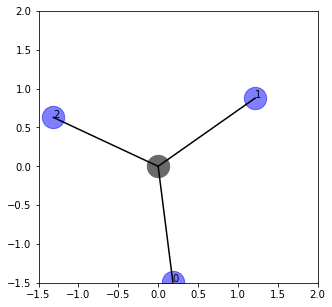

In [59]:
# visualize kernel in the model

params = model.parameters()

param = list(params)
print(len(param))

p_s_array = param[0].detach().numpy()
x_s_array = param[1].detach().numpy()


print('learned kernel positioin')
print(p_s_array)
print('\n')
print('learned kernel attribute')
print(x_s_array)




for i in range(S):
    for j in range(i):
        print(f'{i}-{j} angle:{angle_between_two_vectors(p_s_array[i], p_s_array[j])}')
print('\n')
for i in range(S):
    print(f'{i} length:{edge_length(p_s_array[i])}')

output_kernel = Data(p_s = torch.tensor(p_s_array), x_s = torch.tensor(x_s_array))
output_model = Kernel(output_kernel)
out = output_model(data)



vis(p_s_array, p_s_origin)



In [81]:
# test of degree consistency
from torch.nn import ModuleList

class KernelSet(Module):
    def __init__(self, dim, f_dim):
        super(KernelSet, self).__init__()        
        self.kernel1 = Kernel(dim=dim, S=1, f_dim=f_dim)
        self.kernel2 = Kernel(dim=dim, S=2, f_dim=f_dim)
        self.kernel3 = Kernel(dim=dim, S=3, f_dim=f_dim)
        self.kernel4 = Kernel(dim=dim, S=4, f_dim=f_dim)
        self.kernel_set = ModuleList(
            [self.kernel1, self.kernel2, self.kernel3, self.kernel4])

    def foward(self, data, degree_index):
        '''
        inputs:
        data: graph data containing feature matrix, adjacency matrix, edge_attr matrix
        '''
        output = torch.cat([x(data) for x in ModuleList], dim=0)
        
kernelset_2d = KernelSet(dim = 2, f_dim = 5)
for item in kernelset_2d.state_dict():
    print(item)


randomizing kernel
randomizing kernel
randomizing kernel
randomizing kernel
kernel1.p_s
kernel1.x_s
kernel2.p_s
kernel2.x_s
kernel3.p_s
kernel3.x_s
kernel4.p_s
kernel4.x_s
kernel_set.0.p_s
kernel_set.0.x_s
kernel_set.1.p_s
kernel_set.1.x_s
kernel_set.2.p_s
kernel_set.2.x_s
kernel_set.3.p_s
kernel_set.3.x_s


In [129]:
# test of getting neighbor_index from center_index
import torch
tensor = torch.randint(15,(2,4), dtype=torch.long)
print('tensor:')
print(tensor)

print('\n')
print('values')
values = torch.arange(10, dtype=torch.long)
print(values)

print('\n')
a = tensor[0]

print(a)
b = a.unsqueeze(1) == values
print(b)
c = b.nonzero()
print(c)
d = c[:,0]
print(d)
tensor[1,d]


def get_neighbor_index(edge_index, center_index):
    a = edge_index[0]
    b = a.unsqueeze(1) == center_index
    c = b.nonzero()
    d = c[:,0]
    
    return edge_index[1,d]

a = get_neighbor_index(tensor, values)

print(f'a:{a}')

tensor:
tensor([[ 5,  2,  3, 11],
        [14,  5, 10, 10]])


values
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])


tensor([ 5,  2,  3, 11])
tensor([[False, False, False, False, False,  True, False, False, False, False],
        [False, False,  True, False, False, False, False, False, False, False],
        [False, False, False,  True, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False, False]])
tensor([[0, 5],
        [1, 2],
        [2, 3]])
tensor([0, 1, 2])
a:tensor([14,  5, 10])
